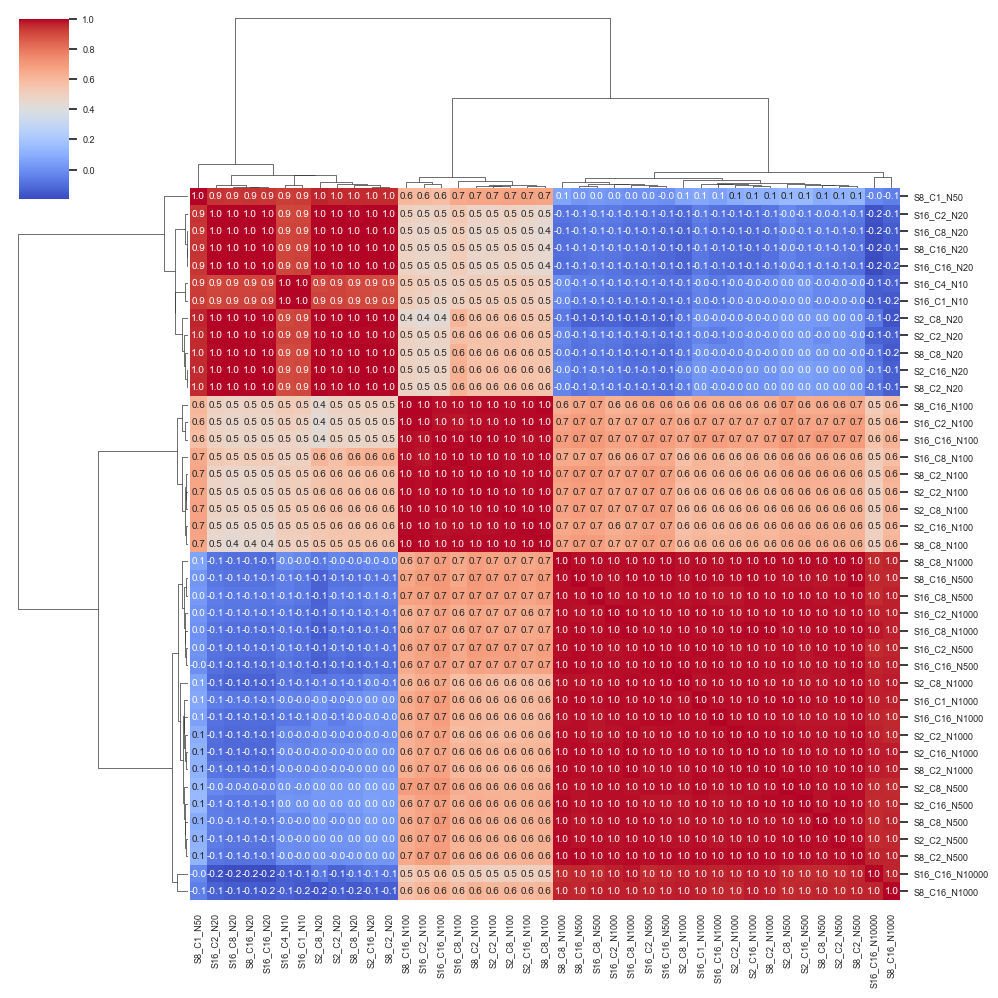

In [345]:
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def get_file_list(base_path, signatures):
    """Generate file lists for the given base path and environment signatures."""
    return [glob.glob(f"{base_path}/{signature}_random_sample*.csv") for signature in signatures]

def load_and_filter_data(file_list, max_config_id, time_threshold=2):
    """Load and filter data based on time and config_id."""
    data_frames = []
    for file in file_list:
        df = pd.read_csv(file)
        df = df[(df['time'] > time_threshold) & (df['config_id'] < max_config_id)]
        data_frames.append(df)
    return pd.concat(data_frames, axis=0, ignore_index=True) if data_frames else pd.DataFrame()

# Configuration: Base path and environment signatures
BASE_PATH = "C:/Users/bened/Desktop/Uni/repos/xdbc-client/experiments/model_optimizer/random_samples_1310k"
ENV_SIGNATURES = [
#orignal 9 environments
"S16_C16_N1000","S16_C8_N100","S8_C1_N50","S16_C16_N10000","S16_C4_N10","S8_C8_N500","S2_C2_N20","S16_C1_N1000","S16_C1_N10",
    
# additional 32 environments
            "S2_C2_N100","S2_C2_N500","S2_C2_N1000",
"S2_C8_N20","S2_C8_N100","S2_C8_N500","S2_C8_N1000",
"S2_C16_N20","S2_C16_N100","S2_C16_N500","S2_C16_N1000",
"S8_C2_N20","S8_C2_N100","S8_C2_N500","S8_C2_N1000",
"S8_C8_N20","S8_C8_N100",             "S8_C8_N1000",
"S8_C16_N20","S8_C16_N100","S8_C16_N500","S8_C16_N1000",
"S16_C2_N20","S16_C2_N100","S16_C2_N500","S16_C2_N1000",
"S16_C8_N20",              "S16_C8_N500","S16_C8_N1000",
"S16_C16_N20","S16_C16_N100","S16_C16_N500"
]



# Generate file lists and heatmap DataFrame
file_lists = get_file_list(BASE_PATH, ENV_SIGNATURES)
df_heatmap = pd.DataFrame(0, index=ENV_SIGNATURES, columns=ENV_SIGNATURES, dtype=float)

# Maximum config ID to filter and heatmap calculation
N = 50
for i, file_list_outer in enumerate(file_lists):
    data_outer = load_and_filter_data(file_list_outer, N)
    for j, file_list_inner in enumerate(file_lists):
        data_inner = load_and_filter_data(file_list_inner, N)
        if not data_outer.empty and not data_inner.empty:
            df_heatmap.iloc[i, j] = calculate_similarity_spearman(data_outer, data_inner)
            #df_heatmap.iloc[i, j] = calculate_similarity_pearson(data_outer, data_inner)
            #df_heatmap.iloc[i, j] = calculate_similarity_cosine(data_outer, data_inner)
            #df_heatmap.iloc[i, j] = calculate_similarity_euclidian(data_outer, data_inner)

#sns.heatmap(df_heatmap, annot=True)

# Plot the heatmap
sns.set(font_scale=0.6)
sns.clustermap(
    df_heatmap,
    method="average",
    cmap="coolwarm",
    annot=True,
    fmt=".1f",
    yticklabels=True,
    xticklabels=True
)
plt.show()

In [72]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def calculate_similarity_cosine(df1, df2):
    # Sort by 'config_id'
    df1_sorted = df1.sort_values(by='config_id').reset_index(drop=True)
    df2_sorted = df2.sort_values(by='config_id').reset_index(drop=True)

    # Align on 'config_id'
    aligned = df1_sorted.merge(df2_sorted, on='config_id', suffixes=('_1', '_2'))
    
    # Extract the 'time' columns
    time1 = aligned['time_1'].values.reshape(1, -1)  # Reshape for cosine similarity
    time2 = aligned['time_2'].values.reshape(1, -1)
    
    # Calculate cosine similarity
    similarity = cosine_similarity(time1, time2)[0, 0]
    return similarity

from scipy.spatial.distance import euclidean

def calculate_similarity_euclidian(df1, df2):
    # Sort and align data as before
    df1_sorted = df1.sort_values(by='config_id').reset_index(drop=True)
    df2_sorted = df2.sort_values(by='config_id').reset_index(drop=True)
    aligned = df1_sorted.merge(df2_sorted, on='config_id', suffixes=('_1', '_2'))

    # Extract the 'time' columns
    time1 = aligned['time_1'].values
    time2 = aligned['time_2'].values

    # Calculate Euclidean distance
    distance = euclidean(time1, time2)
    similarity = 1 / (1 + distance)  # Convert distance to similarity (optional)
    return similarity


def calculate_similarity_pearson(df1, df2):
    # Sort and align data as before
    df1_sorted = df1.sort_values(by='config_id').reset_index(drop=True)
    df2_sorted = df2.sort_values(by='config_id').reset_index(drop=True)
    aligned = df1_sorted.merge(df2_sorted, on='config_id', suffixes=('_1', '_2'))

    # Extract the 'time' columns
    time1 = aligned['time_1'].values
    time2 = aligned['time_2'].values

    # Calculate Pearson correlation
    similarity = np.corrcoef(time1, time2)[0, 1]
    return similarity

from scipy.stats import spearmanr

def calculate_similarity_spearman(df1, df2):
    # Sort and align data as before
    df1_sorted = df1.sort_values(by='config_id').reset_index(drop=True)
    df2_sorted = df2.sort_values(by='config_id').reset_index(drop=True)
    aligned = df1_sorted.merge(df2_sorted, on='config_id', suffixes=('_1', '_2'))

    # Extract the 'time' columns
    time1 = aligned['time_1'].values
    time2 = aligned['time_2'].values

    # Calculate Spearman rank correlation
    similarity, _ = spearmanr(time1, time2)
    return similarity

 Server  Client  Network
      2       2       20
      8       1       50
      8       8      500
     16       1       10
     16       1     1000
     16       4       10
     16       8      100
     16      16     1000
     16      16    10000
Number of Environments : 36
 Server  Client  Network
      2       2       20
      2       2      100
      2       2      500
      2       2     1000
      2       8       20
      2       8      100
      2       8      500
      2       8     1000
      2      16       20
      2      16      100
      2      16      500
      2      16     1000
      8       2       20
      8       2      100
      8       2      500
      8       2     1000
      8       8       20
      8       8      100
      8       8      500
      8       8     1000
      8      16       20
      8      16      100
      8      16      500
      8      16     1000
     16       2       20
     16       2      100
     16       2      500
     16       2     10

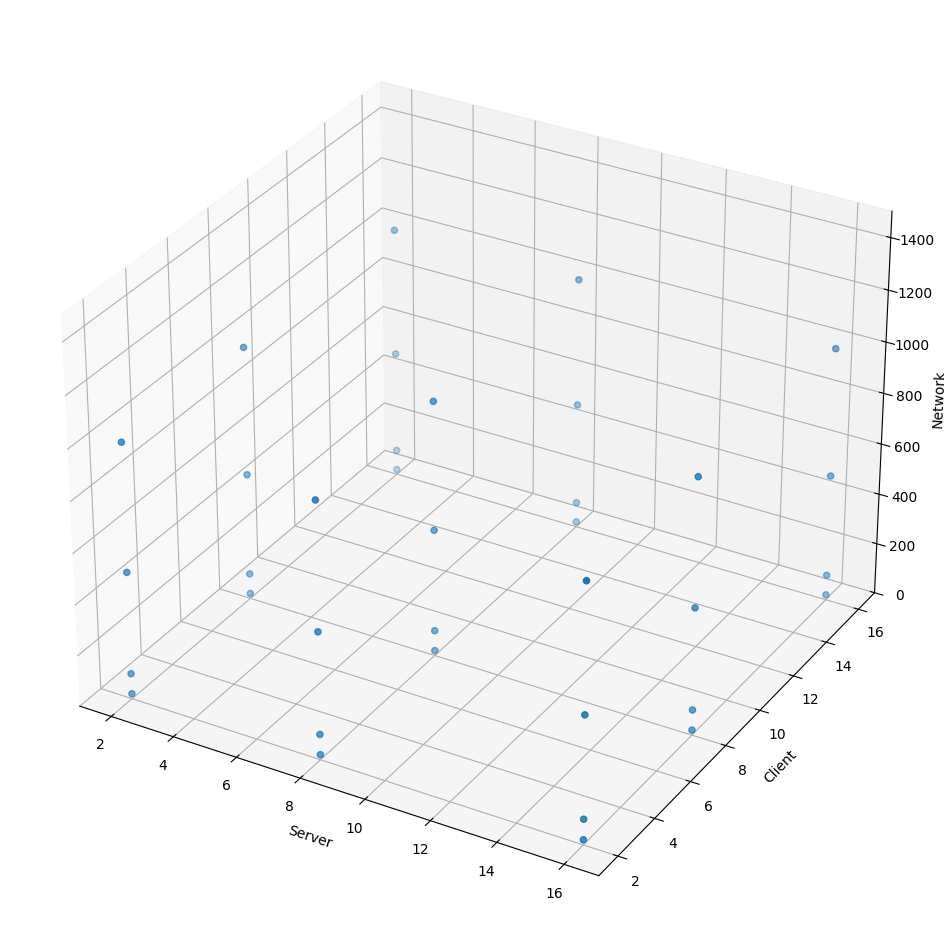

In [171]:
import pandas as pd
import itertools

data = {'Server': [16,16,8,16,16,8,2,16,16],
        'Client': [16,8,1,16,4,8,2,1,1],
        'Network':[1000,100,50,10000,10,500,20,1000,10]}




environments_now = pd.DataFrame(data).sort_values(by=['Server', 'Client', 'Network'],ascending=True)#.reset_index()


print(environments_now.to_string(index=False))

server_values = [2, 8, 16]
client_values = [2, 8, 16]
network_values = [20, 100, 500, 1000]

# Generate all possible combinations
combinations = list(itertools.product(server_values, client_values, network_values))


print("Number of Environments : " + str(len(combinations)))

environments = pd.DataFrame(combinations, columns=['Server', 'Client', 'Network'])

print(environments.to_string(index=False))



fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(environments.Server,environments.Client,environments.Network)
ax.set_xlabel('Server')
ax.set_ylabel('Client')
ax.set_zlabel('Network')
ax.set_zlim(0, 1500)
plt.show()

In [307]:
'''

environment_1 = {
    "server_cpu": 16,
    "client_cpu": 16,
    "network": 1000,
    "timeout": 250
}

'''

i = 10
for index,row in environments.iterrows():
    '''
    print(f"environment_{i} = " + "{")
    print(f"\"server_cpu\": {row["Server"]},")
    print(f"\"client_cpu\": {row["Client"]},")
    print(f"\"network\": {row["Network"]},")
    print(f"\"timeout\": 150")
    print("}")
    '''
    #print(f"environment_{i},", end="")
    #print(f"file_list_env_{i} = glob.glob('C:/Users/bened/Desktop/Uni/repos/xdbc-client/experiments/model_optimizer/random_samples_1310k/S{row["Server"]}_C{row["Client"]}_N{row["Network"]}_random_sample*.csv')")

    #print(f"\"S{row["Server"]}_C{row["Client"]}_N{row["Network"]}\",", end="")
    #print(f"file_list_env_{i},",end="")

    #print(f"env_S{row["Server"]}_C{row["Client"]}_N{row["Network"]} = environment_{i}")


    i = i+1
    